In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import tensorflow as tf
import glob
import os
import matplotlib.pyplot as plt
import numpy as np
import random
from tensorflow.keras import layers
from IPython.display import clear_output

# Load the image

In [ ]:
# Path ke direktori gambar dan masker
image_dir = "/content/drive/MyDrive/[02] Work/[02] Side Hustle/Thermal Body Segmentation/data/images/"
mask_dir = "/content/drive/MyDrive/[02] Work/[02] Side Hustle/Thermal Body Segmentation/data/masks/"

In [ ]:
# Muat daftar path file gambar dan masker
image_file_names = os.listdir(image_dir)
image_paths = [os.path.join(image_dir, file_name) for file_name in image_file_names if file_name.endswith('.png')]

mask_file_names = os.listdir(mask_dir)
mask_paths = [os.path.join(mask_dir, file_name) for file_name in mask_file_names if file_name.endswith('.png')]

# Mengurutkan path gambar dan masker agar sesuai satu sama lain
image_paths.sort()
mask_paths.sort()

In [ ]:
# Menentukan jumlah data untuk pengujian (20% dari total)
test_data_size = int(0.2 * len(image_paths))

# Mengacak indeks untuk data pengujian
test_indices = random.sample(range(len(image_paths)), test_data_size)

# Membuat daftar path gambar dan masker untuk pelatihan dan pengujian
train_image_paths = [image_paths[i] for i in range(len(image_paths)) if i not in test_indices]
train_mask_paths = [mask_paths[i] for i in range(len(mask_paths)) if i not in test_indices]
test_image_paths = [image_paths[i] for i in test_indices]
test_mask_paths = [mask_paths[i] for i in test_indices]

# Dataset pelatihan untuk gambar
image_dataset = tf.data.Dataset.from_tensor_slices(train_image_paths)
mask_dataset = tf.data.Dataset.from_tensor_slices(train_mask_paths)
train_dataset = tf.data.Dataset.zip((image_dataset, mask_dataset))

# Dataset pengujian untuk gambar
test_image_dataset = tf.data.Dataset.from_tensor_slices(test_image_paths)
test_mask_dataset = tf.data.Dataset.from_tensor_slices(test_mask_paths)
test_dataset = tf.data.Dataset.zip((test_image_dataset, test_mask_dataset))

In [ ]:
def normalize(input_image, input_mask):
  input_image = tf.cast(input_image, tf.float32) / 255.0
  input_mask -= 1
  return input_image, input_mask

# Data Preprocessing

In [ ]:
def load_image(image_path, mask_path):
    input_image = tf.io.read_file(image_path)
    input_image = tf.image.decode_png(input_image, channels=3)
    input_image = tf.image.resize(input_image, (256, 256), method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
    input_image = tf.cast(input_image, tf.float32) / 255.0

    input_mask = tf.io.read_file(mask_path)
    input_mask = tf.image.decode_png(input_mask, channels=3)
    input_mask = tf.image.resize(input_mask, (256, 256), method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
    input_mask = tf.cast(input_mask, tf.float32) / 255.0

    return input_image, input_mask

In [ ]:
TRAIN_LENGTH = len(train_dataset)
BATCH_SIZE = 1
BUFFER_SIZE = 100
STEPS_PER_EPOCH = TRAIN_LENGTH // BATCH_SIZE

In [ ]:
train_dataset = train_dataset.map(load_image, num_parallel_calls=tf.data.AUTOTUNE)
test_images = test_dataset.map(load_image, num_parallel_calls=tf.data.AUTOTUNE)

In [ ]:
class Augment(tf.keras.layers.Layer):
  def __init__(self, seed=42):
    super().__init__()
    # both use the same seed, so they'll make the same random changes.
    self.augment_inputs = tf.keras.layers.RandomFlip(mode="horizontal", seed=seed)
    self.augment_labels = tf.keras.layers.RandomFlip(mode="horizontal", seed=seed)

  def call(self, inputs, labels):
    inputs = self.augment_inputs(inputs)
    labels = self.augment_labels(labels)
    return inputs, labels

In [ ]:
train_batches = (train_dataset.cache().shuffle(BUFFER_SIZE).repeat().map(Augment()).batch(BATCH_SIZE).repeat().prefetch(buffer_size=tf.data.AUTOTUNE))
test_batches = test_images.batch(BATCH_SIZE)

# Data Visualization

In [ ]:
def display(display_list):
  plt.figure(figsize=(15, 15))

  title = ['Input Image', 'True Mask', 'Predicted Mask']

  for i in range(len(display_list)):
    plt.subplot(1, len(display_list), i+1)
    plt.title(title[i])
    plt.imshow(tf.keras.utils.array_to_img(display_list[i]))
    plt.axis('off')
  plt.show()

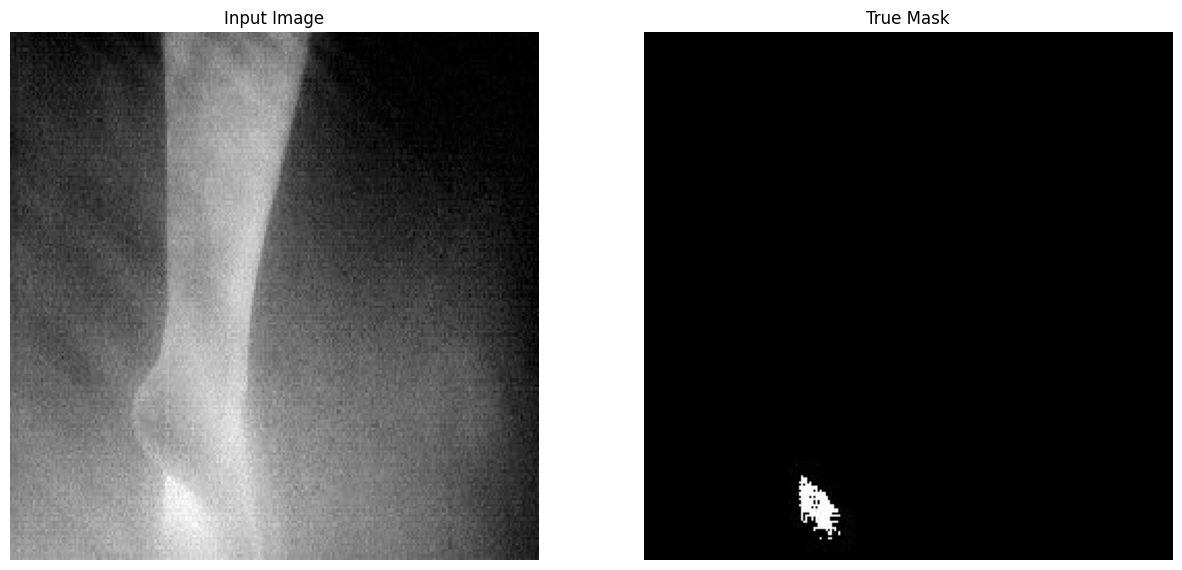

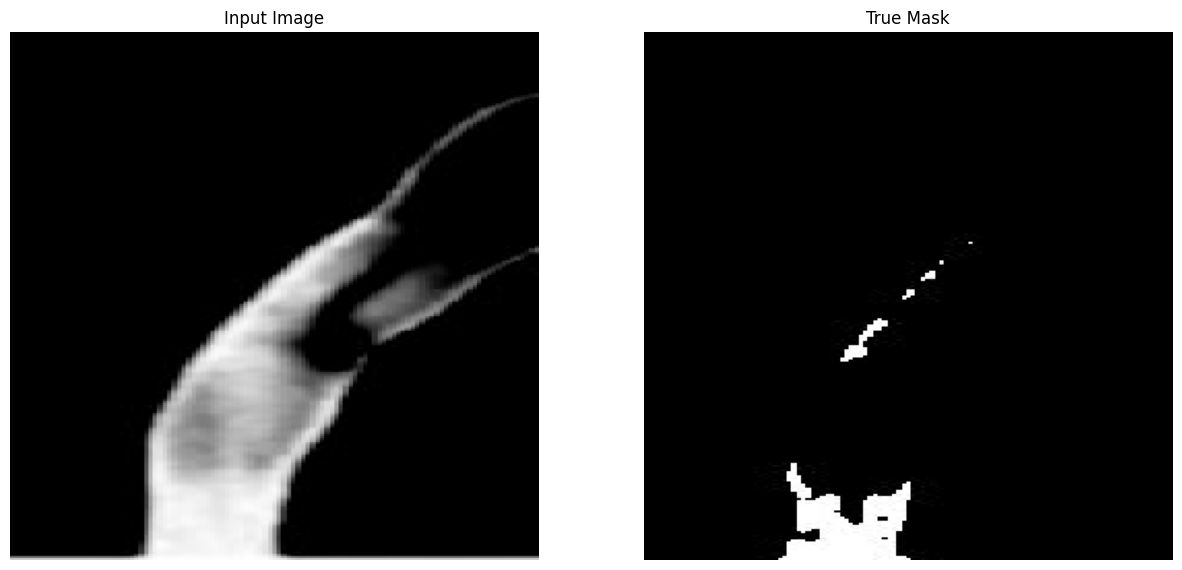

In [ ]:
for images, masks in train_batches.take(2):
  sample_image, sample_mask = images[0], masks[0]
  display([sample_image, sample_mask])

# U-Net Building Blocks

In [ ]:
# Fungsi untuk membuat model U-Net
def double_conv_block(x, n_filters):
    x = layers.Conv2D(n_filters, 3, padding="same", activation="relu", kernel_initializer="he_normal")(x)
    x = layers.Conv2D(n_filters, 3, padding="same", activation="relu", kernel_initializer="he_normal")(x)
    return x

In [ ]:
def downsample_block(x, n_filters):
    f = double_conv_block(x, n_filters)
    p = layers.MaxPool2D(2)(f)
    p = layers.Dropout(0.3)(p)
    return f, p

In [ ]:
def upsample_block(x, conv_features, n_filters):
    x = layers.Conv2DTranspose(n_filters, 3, strides=2, padding="same")(x)
    x = layers.concatenate([x, conv_features])
    x = layers.Dropout(0.3)(x)
    x = double_conv_block(x, n_filters)
    return x


In [ ]:
def build_unet_model():
    inputs = layers.Input(shape=(256,256,3))
    f1, p1 = downsample_block(inputs, 64)
    f2, p2 = downsample_block(p1, 128)
    f3, p3 = downsample_block(p2, 256)
    f4, p4 = downsample_block(p3, 512)
    bottleneck = double_conv_block(p4, 1024)
    u6 = upsample_block(bottleneck, f4, 512)
    u7 = upsample_block(u6, f3, 256)
    u8 = upsample_block(u7, f2, 128)
    u9 = upsample_block(u8, f1, 64)
    outputs = layers.Conv2D(3, 1, padding="same", activation="sigmoid")(u9)
    unet_model = tf.keras.Model(inputs, outputs, name="U-Net")
    return unet_model

In [ ]:
unet_model = build_unet_model()

In [ ]:
unet_model.summary()

Model: "U-Net"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 256, 256, 64)         1792      ['input_1[0][0]']             
                                                                                                  
 conv2d_1 (Conv2D)           (None, 256, 256, 64)         36928     ['conv2d[0][0]']              
                                                                                                  
 max_pooling2d (MaxPooling2  (None, 128, 128, 64)         0         ['conv2d_1[0][0]']            
 D)                                                                                           

In [ ]:
# tf.keras.utils.plot_model(unet_model, show_shapes=True)

# Complie and Train U-Net

In [ ]:
unet_model.compile(optimizer=tf.keras.optimizers.Adam(),
                   loss=tf.keras.losses.BinaryCrossentropy(),
                   metrics=["accuracy"])

In [ ]:
def create_mask(pred_mask):
  pred_mask = tf.math.argmax(pred_mask, axis=-1)
  pred_mask = pred_mask[..., tf.newaxis]
  return pred_mask[0]

In [ ]:
def show_predictions(dataset=None, num=1):
  if dataset:
    for image, mask in dataset.take(num):
      pred_mask = unet_model.predict(image)
      display([image[0], mask[0], create_mask(pred_mask)])
  else:
    display([sample_image, sample_mask,
             create_mask(unet_model.predict(sample_image[tf.newaxis, ...]))])

1/1 [==============================] - 2s 2s/step


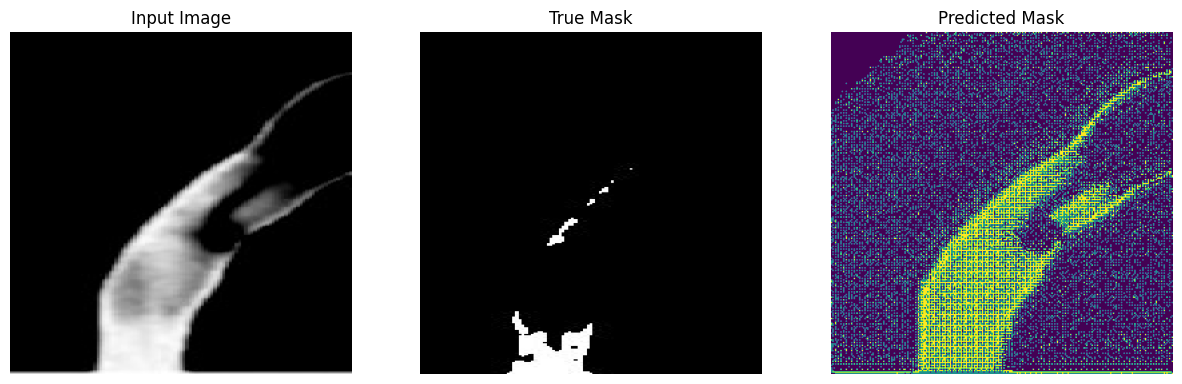

In [ ]:
show_predictions()

## Training

In [ ]:
class DisplayCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs=None):
    clear_output(wait=True)
    show_predictions()
    print ('\nSample Prediction after epoch {}\n'.format(epoch+1))

1/1 [==============================] - 2s 2s/step


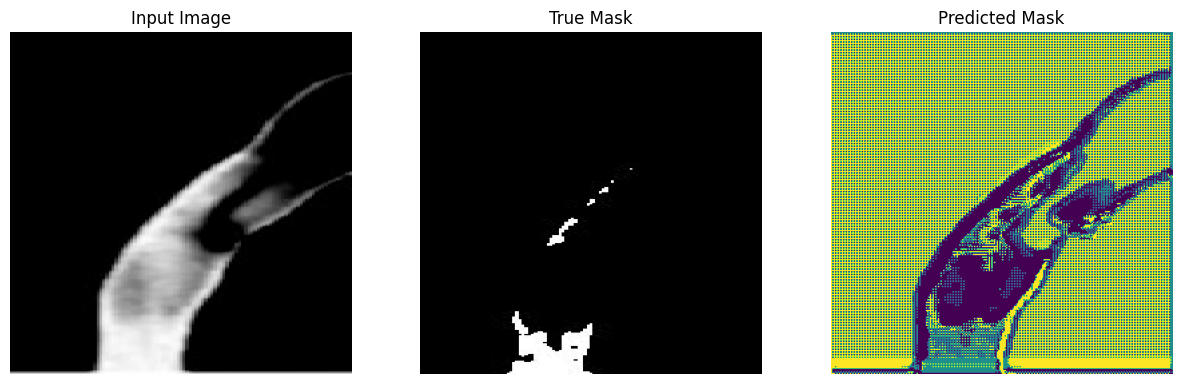


Sample Prediction after epoch 20

96/96 [==============================] - 883s 9s/step - loss: 0.1473 - accuracy: 0.3227 - val_loss: 0.1222 - val_accuracy: 0.6925


In [ ]:
EPOCHS = 20
VAL_SUBSPLITS = 2
VALIDATION_STEPS = test_data_size//BATCH_SIZE//VAL_SUBSPLITS

model_history = unet_model.fit(train_batches, epochs=EPOCHS,
                          steps_per_epoch=STEPS_PER_EPOCH,
                          validation_steps=VALIDATION_STEPS,
                          validation_data=test_batches,
                          callbacks=[DisplayCallback()])

## Learning curve from model history

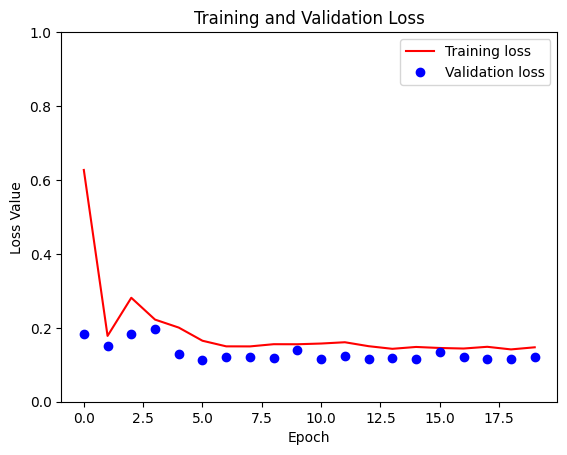

In [ ]:
loss = model_history.history['loss']
val_loss = model_history.history['val_loss']

plt.figure()
plt.plot(model_history.epoch, loss, 'r', label='Training loss')
plt.plot(model_history.epoch, val_loss, 'bo', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss Value')
plt.ylim([0, 1])
plt.legend()
plt.show()

# Predict

1/1 [==============================] - 6s 6s/step


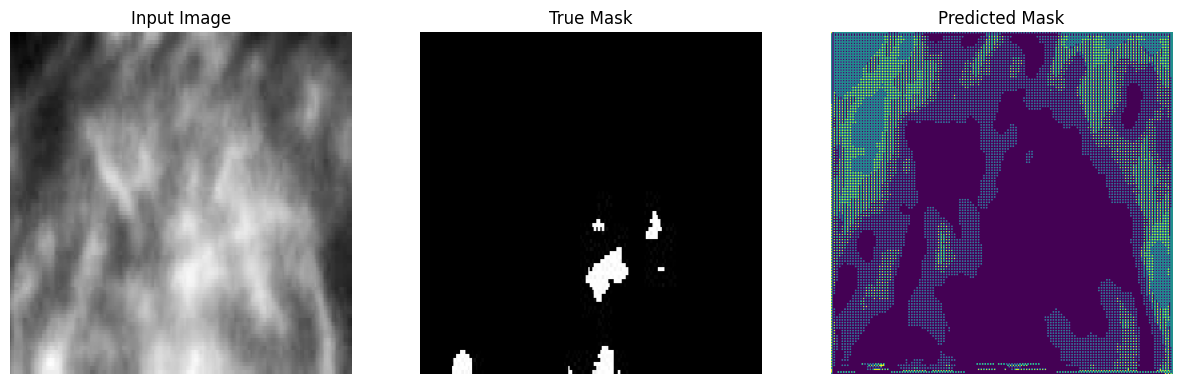

1/1 [==============================] - 3s 3s/step


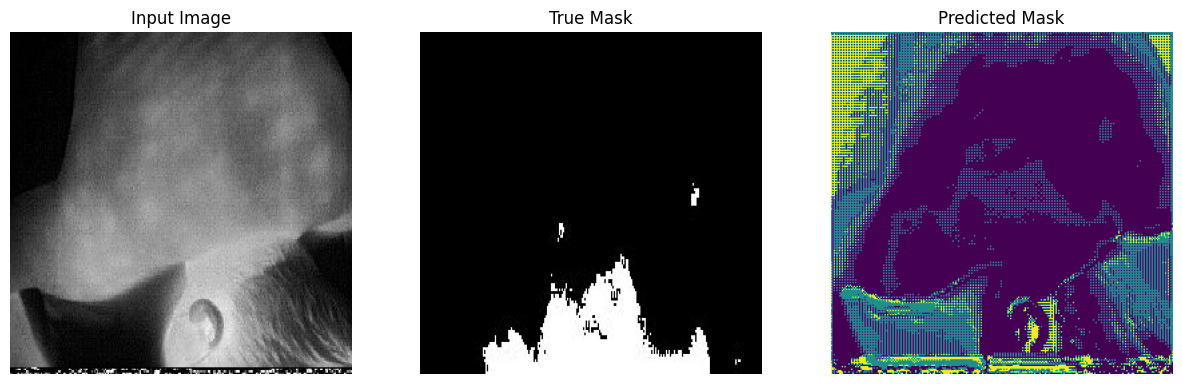

1/1 [==============================] - 2s 2s/step


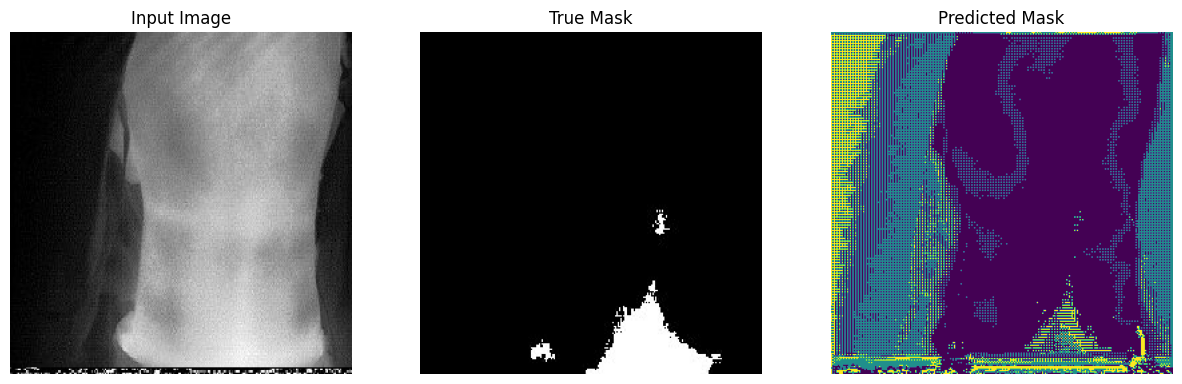

In [ ]:
show_predictions(test_batches, 3)

In [ ]:
# Save Model
unet_model.save("/content/drive/MyDrive/[02] Work/[02] Side Hustle/Body Image Segmentation/model")